In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import tensorflow as tf
from tensorflow import keras

# **1. Load and Preprocess the MNIST Dataset**

On importe le dataset MNIST qui est un dataset qui contient des images des chiffres ecrit à la main.

On sépare le dataset en données d'entrainements et données de test

In [52]:
(x_train_data, y_train_data), (x_val_data, y_val_data) = keras.datasets.mnist.load_data()

On normalise les données d'entrainements entre 0 et 1 pour améliorer la phase d'entrainement du modèle

In [53]:
def preprocessing_function(x, y):
  x_new = tf.cast(x, tf.float32) / 255.0
  y_new = tf.cast(y, tf.int64)
  return x_new, y_new

On encode les labels puis on crée un dataset tensorflow à partir des données de MNIST. On mélange l'odre dans lequel sont rangées les données puis on crée des groupes de 32 combinaisons de données + label.

In [54]:
def func_creating_dataset(x, y, num_classes = 10):
  ys_data = tf.one_hot(y, depth= num_classes)
  return tf.data.Dataset.from_tensor_slices((x, ys_data)) \
         .map(preprocessing_function) \
         .shuffle(buffer_size=1000).batch(3)


In [55]:
train_data = func_creating_dataset(x_train_data, y_train_data)
val_data = func_creating_dataset(x_val_data, y_val_data)

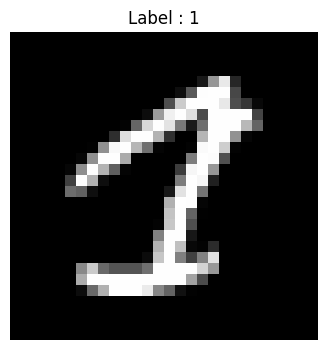

In [60]:
for image, label in train_data.take(1) :
  plt.figure(figsize=(4,4))
  plt.imshow(image[0].numpy().squeeze(), cmap="gray")
  label_index = np.argmax(label[0].numpy())
  plt.title(f"Label : {label_index}")
  plt.axis("off")
  plt.show()

# **2. Build a Fully Connected Neural Network**

On commence par une couche d’entrée de 784 neurones correspondant aux 28×28 pixels de l’image aplatie. Elle est suivie de deux hidden layer avec 256 puis 128 neurones, activées par ReLU pour capter des relations non linéaires. La couche de sortie comprend 10 neurones avec softmax, permettant de prédire la classe parmi les 10 possibles.

In [62]:
Model = keras.Sequential([
    keras.layers.Reshape(target_shape=(28 * 28,), input_shape=(28, 28)),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dense(units=128, activation="relu"),
    keras.layers.Dense(units=10, activation="softmax")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


On compile le modèle avec l'optizer Adam pour une convergence efficace. On utilise la fonction de perte CategoricalCrossentropy avec from_logits=False, ce qui signifie que la couche de sortie applique déjà une fonction softmax. L’accuracy est utilisée comme métrique pour évaluer les performances pendant l’entraînement.

In [64]:
Model.compile(optimizer='adam',
              loss = tf.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# **3. Train the Neural Network**

Le modèle est entraîné pendant 10 époques sur les données d’entraînement répétées en continu. À chaque époque, il effectue 500 itérations (batches) grâce au paramètre steps_per_epoch. Pour évaluer les performances, deux batches du jeu de validation sont utilisés à chaque fin d’époque (validation_steps=2). L’historique de l’entraînement (perte et précision) est stocké dans la variable training.

In [65]:
training = Model.fit(
    train_data.repeat(),
    epochs=10,
    steps_per_epoch=500,
    validation_data=val_data.repeat(),
    validation_steps=2
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6427 - loss: 1.1209 - val_accuracy: 0.6667 - val_loss: 0.6001
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8618 - loss: 0.4367 - val_accuracy: 1.0000 - val_loss: 0.0878
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9025 - loss: 0.3273 - val_accuracy: 1.0000 - val_loss: 0.1372
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9047 - loss: 0.2951 - val_accuracy: 0.6667 - val_loss: 0.4745
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9136 - loss: 0.2841 - val_accuracy: 1.0000 - val_loss: 0.1176
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8902 - loss: 0.3250 - val_accuracy: 0.8333 - val_loss: 0.2266
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9199 - loss: 0.2312 - val_accuracy: 1.0000 - val_loss: 0.0539
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9335 - loss: 0.2054 - val_accuracy:

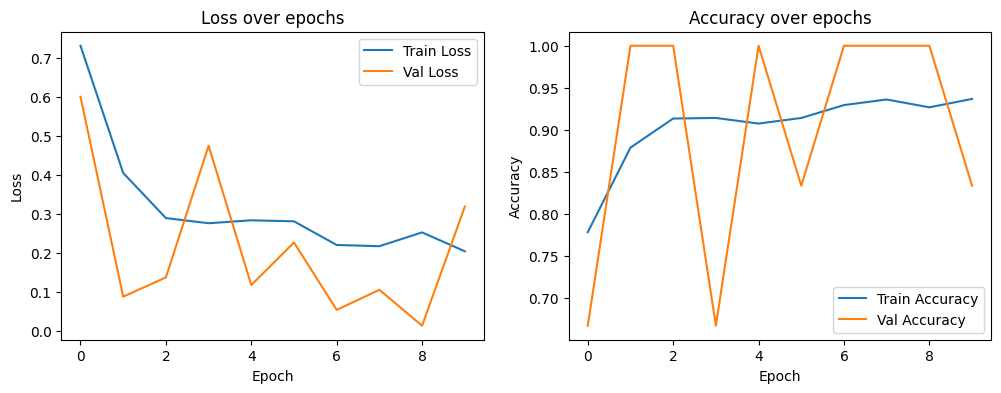

In [69]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training.history['loss'], label="Train Loss")
plt.plot(training.history['val_loss'], label="Val Loss")
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training.history['accuracy'], label="Train Accuracy")
plt.plot(training.history['val_accuracy'], label="Val Accuracy")
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

La perte et la précision sur l'entraînement s'améliorent régulièrement, ce qui montre que le modèle apprend bien. En revanche, les courbes de validation sont très instables.

In [71]:
prediction = Model.predict(val_data)
print(prediction)

3334/3334 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
[[3.0834663e-08 6.6740813e-07 2.2887261e-05 ... 1.6067395e-07
  9.9996161e-01 2.3818093e-06]
 [1.8879367e-03 2.9786045e-04 9.7107947e-01 ... 1.9255495e-03
  1.7980680e-02 1.1097708e-03]
 [5.6457852e-06 1.2518772e-05 3.5649928e-04 ... 3.4210616e-04
  1.3600991e-03 1.3294385e-02]
 ...
 [9.5490500e-04 3.8230547e-04 3.8247468e-04 ... 7.9326856e-01
  2.1261089e-03 1.8745190e-01]
 [9.7517043e-09 1.6876879e-07 9.0934824e-05 ... 9.8340906e-06
  7.3149299e-06 1.0887133e-03]
 [1.5767090e-09 1.9173356e-09 9.4785468e-10 ... 1.9818112e-10
  5.1167217e-04 2.4154886e-08]]


Le modèle effectue des prédictions sur le validation set. Chaque élément de prediction est un vecteur de 10 probabilités correspondant aux 10 classes possibles. La classe prédite est celle dont la probabilité est la plus élevée.

# **4. Evaluate the Model’s Performance**

In [73]:
test_loss, test_accuracy = Model.evaluate(val_data)
print(f"Test Accuracy: {test_accuracy}")

3334/3334 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9254 - loss: 0.2368
Test Accuracy: 0.9326000213623047


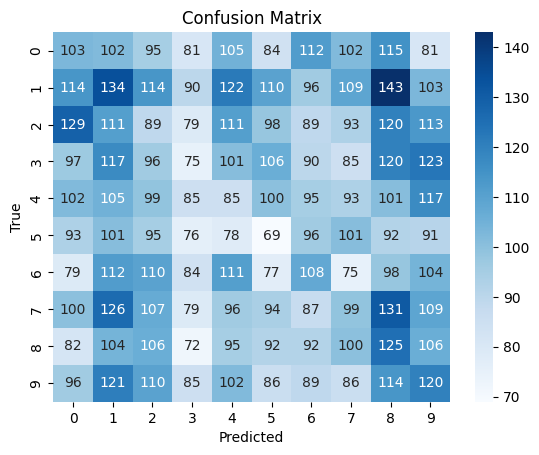

In [78]:
cm = tf.math.confusion_matrix(y_val_data, np.argmax(prediction, axis=1))
sns.heatmap(cm, annot=True, fmt='d', cmap ='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [85]:
cm_numpy = cm.numpy()

totaux = cm_numpy.sum(axis=1)
correct = np.diag(cm_numpy)
erreurs = totaux - correct
pire = np.argmax(erreurs)
print(f"Le chiffre le moins bien prédit est {pire}")

Le chiffre le moins bien prédit est 1


Le chiffre 1 est souvent bien prédit (très haut score sur la diagonale), mais c’est aussi celui qui totalise le plus d’erreurs.